In [8]:
import pandas as pd
from datetime import datetime,timedelta
import requests
import json
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181129 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金



In [77]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class BBICStrategy(CtaTemplate):
    """BBICStrategy"""
    className = 'BBICStrategy'
    author = 'yuanhongjian'
    
    # 策略参数（与参数列表对应）
    BBICPeriod = 20
    lot = 1          # 设置手数
    
    # 策略变量（与变量列表对应）
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['RSIPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称（一般不修改）
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典（对应上面的策略变量）
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
   
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am = self.getArrayManager(symbol, "1m") # 获取历史数组
        
        if not am.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        ma3 = ta.MA(am.close, 3)
        ma6 = ta.MA(am.close, 6)
        ma12 = ta.MA(am.close, 12)
        ma24 = ta.MA(am.close, 24)
        bbi = (ma3 + ma6 + ma12 + ma24)/4
        bbic = bbi/am.close
        
        overBought = bbic[-1] >= 1.02
        overSold = bbic[-1] <= 0.98

        
        # 构建进出场逻辑-------------------------------------------------
        if overSold and (self.posDict[symbol + "_LONG"]==0):
            if self.posDict[symbol + "_SHORT"] == 0:
                self.buy(symbol, bar.close * 1.01, self.lot)
            elif self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
                self.buy(symbol, bar.close * 1.01, self.lot)
        
        elif overBought and (self.posDict[symbol + "_SHORT"] == 0):
            if self.posDict[symbol + "_LONG"] == 0:
                self.short(symbol, bar.close * 0.99, self.lot)
            elif self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
                self.short(symbol, bar.close *0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [78]:
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(BBICStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function BBICStrategy.onBar at 0x119011ea0>, <__main__.BBICStrategy object at 0x116478128>)
2018-12-08 22:40:50.315102	开始回测
2018-12-08 22:40:50.315308	策略初始化
2018-12-08 22:40:50.316710	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-08 22:40:50.963410	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 22:40:50.968789	载入完成，数据量：12000
2018-12-08 22:40:50.969241	策略初始化完成
2018-12-08 22:40:50.969306	策略启动完成
2018-12-08 22:40:50.969380	开始回放回测数据,回测范围:[20180601 12:00,20181129 12:00)
2018-12-08 22:40:50.997743	载入历史数据。数据范围:[20180601 12:00,20181129 12:00)
2018-12-08 22:41:06.256691	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 22:41:06.338869	载入完成，数据量：258848
2018-12-08 22:41:06.339349	当前回放数据:[20180601 12:00,20181129 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-08 22:41:06.342211	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-08 22:41:06.

In [79]:
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-25 00:43:00,多,,,0.0,,开仓,1,,6090.68,0.0,None,,,1,2018-06-25 00:43:00,1,1,BTCUSDT:binance,1
2018-09-06 08:22:00,空,,,0.0,,平仓,2,,6400.22,0.0,None,,,2,2018-09-06 08:22:00,1,2,BTCUSDT:binance,2
2018-09-06 08:22:00,空,,,0.0,,开仓,3,,6400.22,0.0,None,,,3,2018-09-06 08:22:00,1,3,BTCUSDT:binance,3
2018-09-09 17:32:00,多,,,0.0,,平仓,4,,6400.01,0.0,None,,,4,2018-09-09 17:32:00,1,4,BTCUSDT:binance,4
2018-09-09 17:32:00,多,,,0.0,,开仓,5,,6400.01,0.0,None,,,5,2018-09-09 17:32:00,1,5,BTCUSDT:binance,5
2018-10-15 15:12:00,空,,,0.0,,平仓,6,,7100.00,0.0,None,,,6,2018-10-15 15:12:00,1,6,BTCUSDT:binance,6
2018-10-15 15:12:00,空,,,0.0,,开仓,7,,7100.00,0.0,None,,,7,2018-10-15 15:12:00,1,7,BTCUSDT:binance,7
2018-11-15 23:13:00,多,,,0.0,,平仓,8,,5709.02,0.0,None,,,8,2018-11-15 23:13:00,1,8,BTCUSDT:binance,8
2018-11-15 23:13:00,多,,,0.0,,开仓,9,,5709.02,0.0,None,,,9,2018-11-15 23:13:00,1,9,BTCUSDT:binance,9


2018-12-08 22:41:29.331257	计算按日统计结果
2018-12-08 22:41:29.388091	------------------------------
2018-12-08 22:41:29.388642	首个交易日：	2018-06-01 00:00:00
2018-12-08 22:41:29.388720	最后交易日：	2018-11-29 00:00:00
2018-12-08 22:41:29.388770	总交易日：	182
2018-12-08 22:41:29.388817	盈利交易日	77
2018-12-08 22:41:29.388865	亏损交易日：	79
2018-12-08 22:41:29.388927	起始资金：	1000000
2018-12-08 22:41:29.389202	结束资金：	1,001,998.93
2018-12-08 22:41:29.389528	总收益率：	0.2%
2018-12-08 22:41:29.389633	年化收益：	0.26%
2018-12-08 22:41:29.389704	总盈亏：	1,998.93
2018-12-08 22:41:29.389792	最大回撤: 	-2,202.09
2018-12-08 22:41:29.390010	百分比最大回撤: -0.22%
2018-12-08 22:41:29.390093	总手续费：	36.87
2018-12-08 22:41:29.390195	总滑点：	0.03
2018-12-08 22:41:29.390260	总成交金额：	73,736.04
2018-12-08 22:41:29.390320	总成交笔数：	13
2018-12-08 22:41:29.390379	日均盈亏：	10.98
2018-12-08 22:41:29.390433	日均手续费：	0.2
2018-12-08 22:41:29.390557	日均滑点：	0.0
2018-12-08 22:41:29.390663	日均成交金额：	405.14
2018-12-08 22:41:29.390726	日均成交笔数：	0.07
2018-12-08 22:41:29.390857	日均收益率：	0.0%
2018

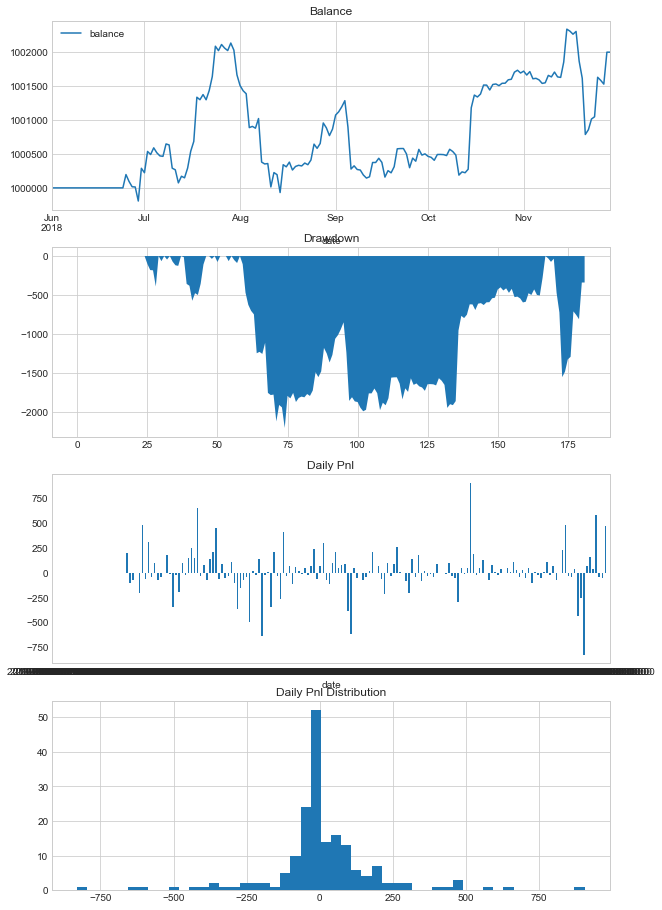

In [80]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-08 22:41:32.566851	计算回测结果
2018-12-08 22:41:32.568225	------------------------------
2018-12-08 22:41:32.568648	第一笔交易：	2018-09-06 08:22:00
2018-12-08 22:41:32.568726	最后一笔交易：	2018-11-29 11:58:00
2018-12-08 22:41:32.568787	总交易次数：	7
2018-12-08 22:41:32.568855	总盈亏：	1,912.98
2018-12-08 22:41:32.568922	最大回撤: 	-1,333.78
2018-12-08 22:41:32.568986	平均每笔盈利：	273.28
2018-12-08 22:41:32.569099	平均每笔滑点：	0.0
2018-12-08 22:41:32.569162	平均每笔佣金：	5.56
2018-12-08 22:41:32.569222	胜率		71.43%
2018-12-08 22:41:32.569280	盈利交易平均值	650.59
2018-12-08 22:41:32.569338	亏损交易平均值	-669.99
2018-12-08 22:41:32.569397	盈亏比：	0.97


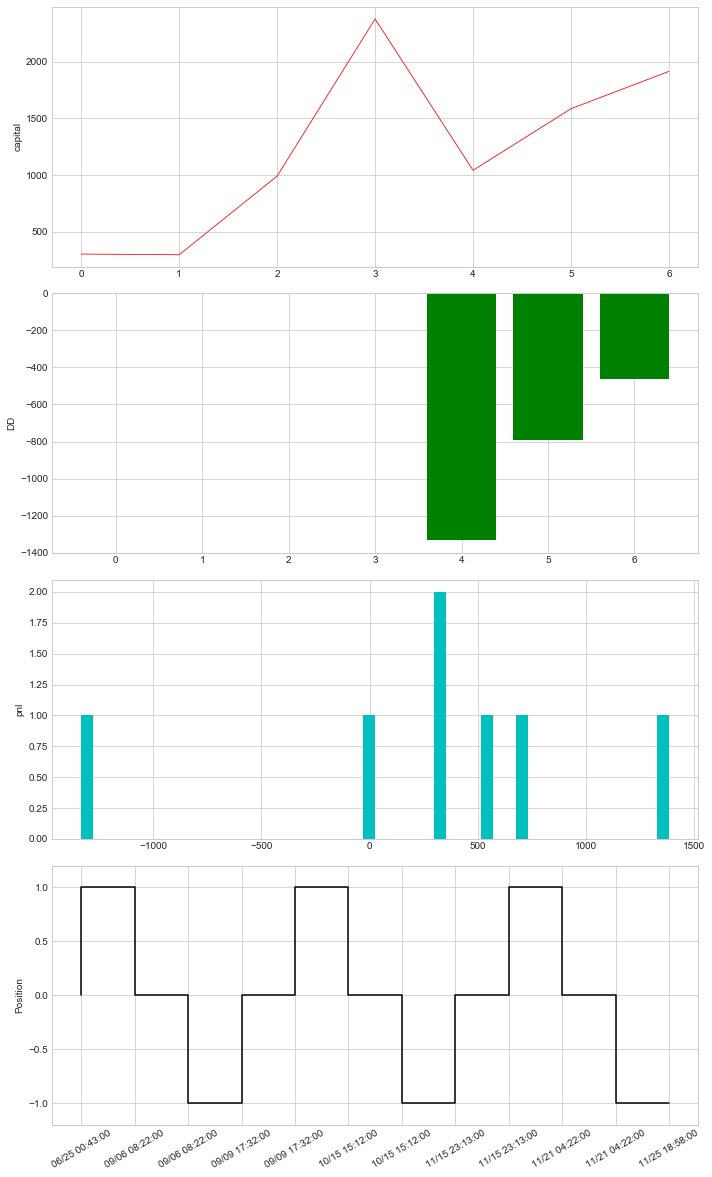

In [81]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [82]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-08 22:41:33.571540	计算按日统计结果


In [83]:
print(pd.Series(result)) # 显示绩效指标

annualizedReturn               0.263595
dailyCommission                0.202572
dailyNetPnl                     10.9831
dailyReturn                  0.00109721
dailySlippage               0.000142857
dailyTradeCount               0.0714286
dailyTurnover                   405.143
endBalance                    1.002e+06
endDate             2018-11-29 00:00:00
lossDays                             79
maxDdPercent                   -0.21974
maxDrawdown                    -2202.09
profitDays                           77
returnStd                     0.0192471
sharpeRatio                    0.883145
startDate           2018-06-01 00:00:00
totalCommission                  36.868
totalDays                           182
totalNetPnl                     1998.93
totalReturn                    0.199893
totalSlippage                     0.026
totalTradeCount                      13
totalTurnover                     73736
dtype: object
